In [1]:
%matplotlib inline

In [2]:
import os
import pyxdf
import numpy as np
import mne
import matplotlib.pyplot as plt
import scipy

### Settings

In [3]:
# Files
subject = 'P00J'
session = 1
task = 'MI-hands'
lslDir = r'C:\Users\leungj\Documents\CurrentStudy'

# LSL Stream
eeg_stream_type = 'EXG'
markers_stream_type = 'Marker'

# Experiment parameters
rest_duration = 5
task_duration = 5

# Events
event_dict = {'rest': 0, 'MI/hands': 1}
tmin = 0
tmax = 5

In [4]:
# Find files
xdf_files = []
for root, dir, files in os.walk(lslDir):
    if subject in root:
        for file in files:
            if (subject in file) and (('ses-S' + str(session).zfill(3)) in file) and (task in file):
                matchingFile = os.path.join(root, file)
                print(matchingFile)
                xdf_files.append(matchingFile)

C:\Users\leungj\Documents\CurrentStudy\sub-P00J\ses-S001\eeg\sub-P00J_ses-S001_task-MI-hands_run-001_eeg.xdf
C:\Users\leungj\Documents\CurrentStudy\sub-P00J\ses-S001\eeg\sub-P00J_ses-S001_task-MI-hands_run-002_eeg.xdf
C:\Users\leungj\Documents\CurrentStudy\sub-P00J\ses-S001\eeg\sub-P00J_ses-S001_task-MI-hands_run-003_eeg.xdf
C:\Users\leungj\Documents\CurrentStudy\sub-P00J\ses-S001\eeg\sub-P00J_ses-S001_task-MI-hands_run-004_eeg.xdf
C:\Users\leungj\Documents\CurrentStudy\sub-P00J\ses-S001\eeg\sub-P00J_ses-S001_task-MI-hands_run-005_eeg.xdf


In [5]:
# Parse streams
eeg_stream, marker_stream = [], []

print('Parsing streams')
for xdf_file in xdf_files:
    streams, header = pyxdf.load_xdf(xdf_file)
    for i in range(len(streams)):
        if streams[i]['info']['type'][0] == eeg_stream_type:
            print("Found %s stream in %s" % (eeg_stream_type, os.path.basename(xdf_file)))
            eeg_stream.append(streams[i])
        elif streams[i]['info']['type'][0] == markers_stream_type:
            print("Found %s stream in %s" % (markers_stream_type, os.path.basename(xdf_file)))
            marker_stream.append(streams[i])
del streams, header

Parsing streams
Found Marker stream in sub-P00J_ses-S001_task-MI-hands_run-001_eeg.xdf
Found EXG stream in sub-P00J_ses-S001_task-MI-hands_run-001_eeg.xdf
Found EXG stream in sub-P00J_ses-S001_task-MI-hands_run-002_eeg.xdf
Found Marker stream in sub-P00J_ses-S001_task-MI-hands_run-002_eeg.xdf
Found EXG stream in sub-P00J_ses-S001_task-MI-hands_run-003_eeg.xdf
Found Marker stream in sub-P00J_ses-S001_task-MI-hands_run-003_eeg.xdf
Found EXG stream in sub-P00J_ses-S001_task-MI-hands_run-004_eeg.xdf
Found Marker stream in sub-P00J_ses-S001_task-MI-hands_run-004_eeg.xdf
Found EXG stream in sub-P00J_ses-S001_task-MI-hands_run-005_eeg.xdf
Found Marker stream in sub-P00J_ses-S001_task-MI-hands_run-005_eeg.xdf


In [21]:
# Extract EEG data
print("Extracting EEG info")

ch_names = []
if eeg_stream[0]['info']['desc'][0]:
    print("EEG channel names found")
    for i in range(len(eeg_stream[0]['info']['desc'][0]['channels'][0]['channel'])):
        ch_names.append(eeg_stream[0]['info']['desc'][0]['channels'][0]['channel'][i]['label'][0])
else:
    print("EEG channel names not found... setting default")
    ch_names = ['FP1', 'FP2', 'C3', 'C4', 'P7', 'P8', 'O1', 'O2', 'F7', 'F8', 'F3', 'F4', 'T7', 'T8', 'P3', 'P4']
print('Channels: ', ch_names)

sfreq = float(eeg_stream[0]['info']['nominal_srate'][0])
print('Sampling frequency: ', sfreq)

# Create MNE info object
eeg_info = mne.create_info(ch_names, sfreq, ch_types='eeg')

Extracting EEG info
EEG channel names not found... setting default
Channels:  ['FP1', 'FP2', 'C3', 'C4', 'P7', 'P8', 'O1', 'O2', 'F7', 'F8', 'F3', 'F4', 'T7', 'T8', 'P3', 'P4']
Sampling frequency:  125.0


In [9]:
montage = mne.channels.read_custom_montage('openbci_montage.elc')

In [10]:
# Get all EEG data
eeg_epoch_list = []

for n in range(len(eeg_stream)):
    # Create MNE Raw object
    eeg_data = np.transpose(eeg_stream[n]['time_series'])
    eeg_data = eeg_data / 1e6
    print(eeg_data.shape)
    eeg_raw = mne.io.RawArray(eeg_data, eeg_info)
    
    # Set montage
    eeg_raw.set_montage(montage)

    # Add annotations
    onset, duration, description = [], [], []
    for i in range(len(marker_stream[n]['time_series'])):
        if ('rest' in marker_stream[n]['time_series'][i][0]):
            onset.append(marker_stream[n]['time_stamps'][i] - eeg_stream[n]['time_stamps'][0])
            duration.append(rest_duration)
            description.append(marker_stream[n]['time_series'][i][0])
        elif ('task' in marker_stream[n]['time_series'][i][0]):
            onset.append(marker_stream[n]['time_stamps'][i] - eeg_stream[n]['time_stamps'][0])
            duration.append(task_duration)
            description.append(marker_stream[n]['time_series'][i][0].replace('task_', '').replace('-','/'))
    annotations = mne.Annotations(onset, duration, description)
    eeg_raw = eeg_raw.set_annotations(annotations)
    
    # Epoch data
    events, event_id = mne.events_from_annotations(eeg_raw, event_id=event_dict)
    eeg_epoch = mne.Epochs(eeg_raw, events, event_id=event_id, tmin=tmin, tmax=tmax, baseline=None, picks='eeg', preload=True, detrend=1)
    eeg_epoch_list.append(eeg_epoch)
    print(eeg_epoch)

(16, 22024)
Creating RawArray with float64 data, n_channels=16, n_times=22024
    Range : 0 ... 22023 =      0.000 ...   176.184 secs
Ready.
Used Annotations descriptions: ['MI/hands', 'rest']
Not setting metadata
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Loading data for 20 events and 626 original time points ...
0 bad epochs dropped
<Epochs |  20 events (all good), 0 - 5 sec, baseline off, ~1.6 MB, data loaded,
 'MI/hands': 10
 'rest': 10>
(16, 21138)
Creating RawArray with float64 data, n_channels=16, n_times=21138
    Range : 0 ... 21137 =      0.000 ...   169.096 secs
Ready.
Used Annotations descriptions: ['MI/hands', 'rest']
Not setting metadata
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Loading data for 20 events and 626 original time points ...
0 bad epochs dropped
<Epochs |  20 events (all good), 0 - 5 sec, baseline off, ~1.6 MB, data loaded,
 'MI/hand

In [11]:
# concatenate all epochs
eeg_epochs = mne.concatenate_epochs(eeg_epoch_list)
eeg_epochs

Not setting metadata
Not setting metadata
100 matching events found
No baseline correction applied
0 bad epochs dropped


Number of events,100
Events,MI/hands: 50rest: 50
Time range,0.000 – 5.000 sec
Baseline,off


In [12]:
# Re-reference data
eeg_epochs = eeg_epochs.set_eeg_reference ('average', projection=False)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


In [13]:
# Filter data
l_freq = 40.
h_freq = 1.
eeg_epochs = eeg_epochs.filter(l_freq, h_freq, n_jobs=-1)

Setting up band-stop filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 413 samples (3.304 sec)



[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  10 tasks      | elapsed:    5.9s
[Parallel(n_jobs=8)]: Done 197 tasks      | elapsed:    6.2s
[Parallel(n_jobs=8)]: Done 1454 tasks      | elapsed:    6.8s
[Parallel(n_jobs=8)]: Done 1600 out of 1600 | elapsed:    7.0s finished


Using matplotlib as 2D backend.


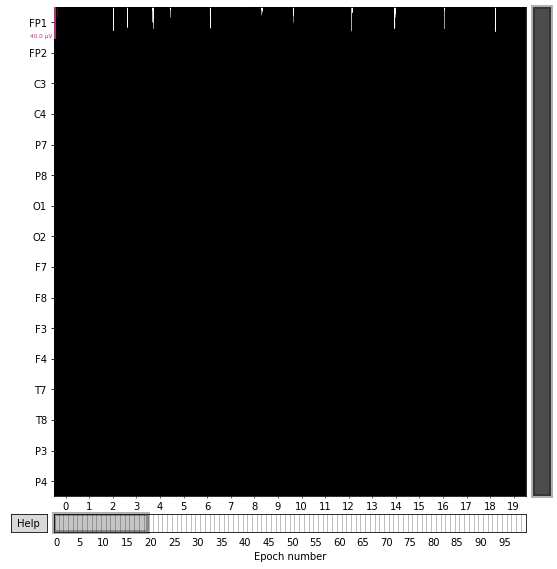

In [14]:
# plot eeg data
fig = eeg_epochs.plot(title='Raw Data', n_channels=len(ch_names), show=True)

    Using multitaper spectrum estimation with 7 DPSS windows


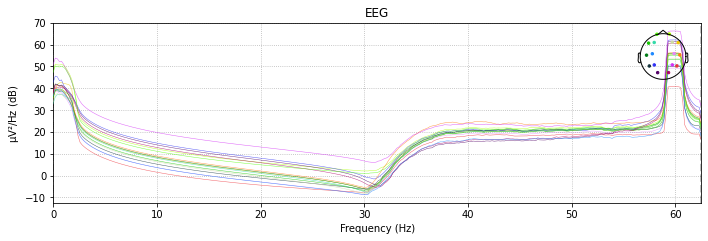

    Using multitaper spectrum estimation with 7 DPSS windows


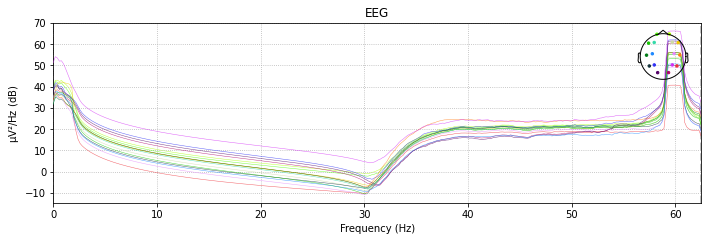

In [15]:
# print(eeg_epochs)

fig = eeg_epochs['rest'].plot_psd()
fig = eeg_epochs['MI/hands'].plot_psd()

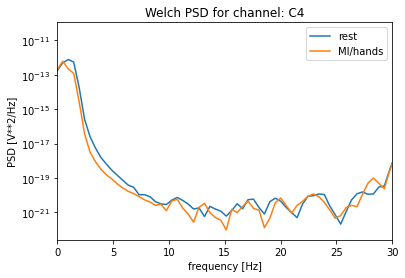

In [16]:
rest_data = eeg_epochs['rest'].get_data()
MI_data = eeg_epochs['MI/hands'].get_data()
f, Pxx_den_rest = scipy.signal.welch(np.mean(rest_data, 0), fs=125.)
f, Pxx_den_MI = scipy.signal.welch(np.mean(MI_data, 0), fs=125.)


channel = 3
plt.title('Welch PSD for channel: %s' % ch_names[channel])
plt.semilogy(f, Pxx_den_rest[channel,:])
plt.semilogy(f, Pxx_den_MI[channel,:])
plt.xlim([0, 30])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.legend(['rest', 'MI/hands'])
plt.show()